In [1]:
import pandas as pd 
import ast 
api_results_xls = pd.ExcelFile('../retrieval_results/api_retrieved_final.xlsx')
api_results_dct = {} 
for sheet in api_results_xls.sheet_names: 
    api_results_dct[sheet] = pd.read_excel('../retrieval_results/api_retrieved_final.xlsx', sheet_name = sheet)


# Find Extent of Overlap Between Databases (based on Included Article ID)

In [2]:
api_results_dct.keys()

dict_keys(['api_results_oa', 'metrics_oa', 'unsucessful_retrieve_oa', 'api_results_ss', 'metrics_ss', 'unsucessful_retrieve_ss', 'api_results_pubmed', 'metrics_pubmed', 'unsucessful_retrieve_pubmed', 'api_results_embase', 'metrics_embase', 'unsucessful_retrieve_embase'])

In [3]:
import upsetplot 
from upsetplot import UpSet
import pandas as pd
import matplotlib.pyplot as plt

# Calculate total unique articles

# Assuming api_results_dct contains your data
oa_successful = api_results_dct['api_results_oa'].query('(api_retrieval_success == 1)')
ss_successful = api_results_dct['api_results_ss'].query('(api_retrieval_success == 1)')
pmed_successful = api_results_dct['api_results_pubmed'].query('(api_retrieval_success == 1)')
emb_successful = api_results_dct['api_results_embase'].query('(api_retrieval_success == 1)')


# Function to get article IDs
def get_article_ids(df):
    return set(df['included_article_id'])

# Get sets of article IDs for each database
oa_ids = get_article_ids(oa_successful)
ss_ids = get_article_ids(ss_successful)
pmed_ids = get_article_ids(pmed_successful)
emb_ids = get_article_ids(emb_successful)

# Get all unique article IDs
all_ids = oa_ids.union(ss_ids, pmed_ids, emb_ids)

# Create a DataFrame with MultiIndex
data = pd.DataFrame(index=pd.MultiIndex.from_product(
    [[False, True] for _ in range(4)],
    names=['OpenAlex', 'Semantic Scholar', 'PubMed', 'Embase']
))

# Count occurrences
data['count'] = [sum((id in oa_ids) == oa and
                     (id in ss_ids) == ss and
                     (id in pmed_ids) == pmed and
                     (id in emb_ids) == emb
                     for id in all_ids)
                 for oa, ss, pmed, emb in data.index]

data = data.query('count > 0')

# Create and show the UpSet plot
colors = {
    'PubMed': '#FF9999',
    'Embase': '#66B2FF',
    'Semantic Scholar': '#99FF99',
    'OpenAlex': '#FFCC99'
}

fig = plt.figure(figsize=(10, 5))
upset_plt = upsetplot.plot(data['count'], sort_by='cardinality', show_percentages=True, show_counts = True, element_size = None, totals_plot_elements=0)

plt.suptitle('Extent of Overlap of Successful Article Retrievals Across ALL Tested Databases')
# Print some diagnostic information
print(f"Total unique articles: {len(all_ids)}")
print(f"OpenAlex: {len(oa_ids)}")
print(f"Semantic Scholar: {len(ss_ids)}")
print(f"PubMed: {len(pmed_ids)}")
print(f"Embase: {len(emb_ids)}")

ModuleNotFoundError: No module named 'upsetplot'

# Plot Risk of Bias of Articles that Were Missed 

In [49]:
oa_unsucessful = api_results_dct['unsucessful_retrieve_oa']
ss_unsucessful = api_results_dct['unsucessful_retrieve_ss']
pmed_unsucessful = api_results_dct['unsucessful_retrieve_pubmed']
emb_unsucessful = api_results_dct['unsucessful_retrieve_embase']

#merge all unsuccessful articles into a single dataframe and drop duplicates 
all_unsuccessful = pd.concat([oa_unsucessful, ss_unsucessful, pmed_unsucessful, emb_unsucessful])
all_unsuccessful_nodupe = all_unsuccessful.drop_duplicates(subset = ['included_article_id'])
all_unsuccessful_nodupe.to_csv('all_unsuccessful_nodupe.csv')


In [50]:
#read in csv file with extracted assessed rob 
all_unsucessful_rob = pd.read_csv('all_unsuccessful_nodupe_rob.csv')
all_unsucessful_rob['rob'] = all_unsucessful_rob['rob'].str.strip()
#map extracted rob back to original unsuccessful api retrieval results, included_article_id as index 
all_unsucessful_rob.set_index('included_article_id', inplace = True)
ss_unsucessful.set_index('included_article_id', inplace = True)
pmed_unsucessful.set_index('included_article_id', inplace = True)
emb_unsucessful.set_index('included_article_id', inplace = True)
oa_unsucessful.set_index('included_article_id', inplace = True)


In [51]:

oa_unsucessful_with_rob = oa_unsucessful.join(all_unsucessful_rob[['rob']], how='left')
oa_unsucessful_with_rob.reset_index(inplace = True)

ss_unsucessful_with_rob = ss_unsucessful.join(all_unsucessful_rob[['rob']], how='left')
ss_unsucessful_with_rob.reset_index(inplace = True)

pmed_unsucessful_with_rob = pmed_unsucessful.join(all_unsucessful_rob[['rob']], how='left')
pmed_unsucessful_with_rob.reset_index(inplace = True)

emb_unsucessful_with_rob = emb_unsucessful.join(all_unsucessful_rob[['rob']], how='left')
emb_unsucessful_with_rob.reset_index(inplace = True)




In [52]:
emb_unsucessful_with_rob['rob'].unique()

array(['moderate', 'low', 'high', 'insufficient information'],
      dtype=object)

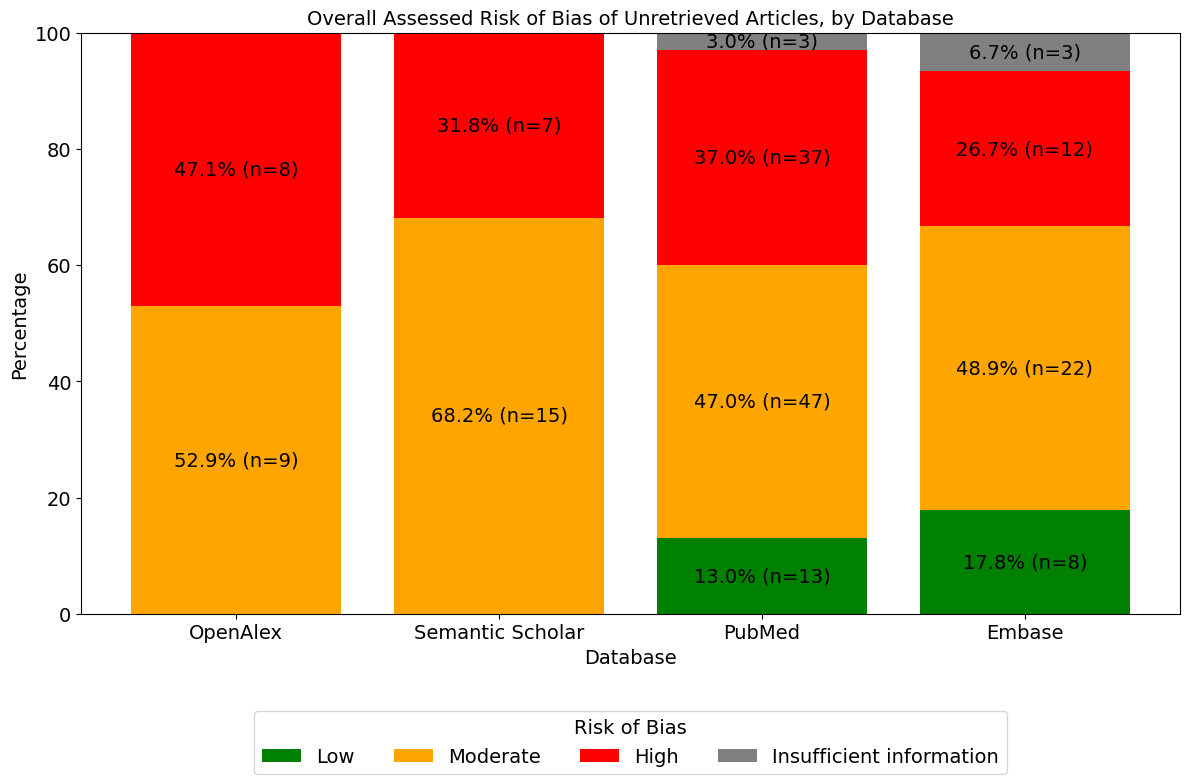

: 

In [63]:
#plot rob by database, percentage as bar chart 
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Prepare the data
databases = {
    'OpenAlex': oa_unsucessful_with_rob,
    'Semantic Scholar': ss_unsucessful_with_rob,
    'PubMed': pmed_unsucessful_with_rob,
    'Embase': emb_unsucessful_with_rob
}

# Step 2: Calculate percentages for each RoB category in each database
rob_percentages = {}
rob_counts = {}
for db_name, df in databases.items():
    total = df['rob'].notna().sum()
    rob_percentages[db_name] = df['rob'].value_counts(normalize=True).mul(100).round(2)
    rob_counts[db_name] = df['rob'].value_counts()

# Step 3: Prepare data for plotting
rob_categories = ['low', 'moderate', 'high', 'insufficient information']
data = {cat: [rob_percentages[db].get(cat, 0) for db in databases.keys()] for cat in rob_categories}

# Step 4: Create the stacked bar chart
fig, ax = plt.subplots(figsize=(12, 8))

# Define colors for each RoB category
colors = {'low': 'green', 'moderate': 'orange', 'high': 'red', 'insufficient information': 'grey'}

bottom = np.zeros(len(databases))
for cat in rob_categories:
    ax.bar(databases.keys(), data[cat], bottom=bottom, label=cat.capitalize(), color=colors[cat])
    bottom += data[cat]

ax.set_title('Overall Assessed Risk of Bias of Unretrieved Articles, by Database', fontsize=14)
ax.set_xlabel('Database', fontsize=14)
ax.set_ylabel('Percentage', fontsize=14)
ax.legend(title='Risk of Bias', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=4, fontsize=14, title_fontsize=14)
ax.set_ylim(0, 100)

# Add percentage labels and n= on the bars
for i, db in enumerate(databases.keys()):
    total = sum(data[cat][i] for cat in rob_categories)
    y_offset = 0
    for cat in rob_categories:
        height = data[cat][i]
        if height > 0:
            count = rob_counts[db].get(cat, 0)
            ax.text(i, y_offset + height/2, f'{height:.1f}% (n={count})', 
                    ha='center', va='center', fontsize=14)
        y_offset += height

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()
